##### Copyright 2022 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Core  API を使用したロジスティック回帰で二項分類を実行する

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/guide/core/logistic_regression_core"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/guide/core/logistic_regression_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/guide/core/logistic_regression_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/guide/core/logistic_regression_core.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このガイドでは、[TensorFlow Core 低レベル API](https://www.tensorflow.org/guide/core) を使用して、[ロジスティック回帰](https://developers.google.com/machine-learning/crash-course/logistic-regression/){:.external} で[二項分類](https://developers.google.com/machine-learning/glossary#binary_classification){:.external} を実行する方法を示します。腫瘍の分類には [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)){:.external} を使用します。

[ロジスティック回帰](https://developers.google.com/machine-learning/crash-course/logistic-regression/){:.external} は、二項分類で最も一般的なアルゴリズムの 1 つです。ロジスティック回帰の目標は、特徴のある一連のサンプルから、各サンプルが特定のクラスに属する確率として 0 から 1 の間の値を出力することです。 

## セットアップ

このチュートリアルでは、CSV ファイルを [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html){:.external} に読み込むために [pandas](https://pandas.pydata.org){:.external}、データセット内のペアワイズ関係をプロットするために [seaborn](https://seaborn.pydata.org){:.external}、混同行列を計算するために [Scikit-learn](https://scikit-learn.org/){:.external}、視覚化を作成するために [matplotlib](https://matplotlib.org/){:.external} を使用します。

In [2]:
!pip install -q seaborn

In [3]:
import tensorflow as tf
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import tempfile
import os

# Preset matplotlib figure sizes.
matplotlib.rcParams['figure.figsize'] = [9, 6]

print(tf.__version__)
# To make the results reproducible, set the random seed value.
tf.random.set_seed(22)

2024-01-11 19:10:19.363685: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 19:10:19.363730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 19:10:19.365299: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


## データを読み込む

次に、[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/){:.external} から [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)){:.external} を読み込みます。 このデータセットには、腫瘍の半径、テクスチャ、凹面などのさまざまな特徴が含まれています。

In [4]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

features = ['radius', 'texture', 'perimeter', 'area', 'smoothness', 'compactness',
            'concavity', 'concave_poinits', 'symmetry', 'fractal_dimension']
column_names = ['id', 'diagnosis']

for attr in ['mean', 'ste', 'largest']:
  for feature in features:
    column_names.append(feature + "_" + attr)

[`pandas.read_csv`](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html){:.external} を使用して、データセットを pandas [DataFrame](){:.external} に読み取ります。

In [5]:
dataset = pd.read_csv(url, names=column_names)

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         569 non-null    int64  
 1   diagnosis                  569 non-null    object 
 2   radius_mean                569 non-null    float64
 3   texture_mean               569 non-null    float64
 4   perimeter_mean             569 non-null    float64
 5   area_mean                  569 non-null    float64
 6   smoothness_mean            569 non-null    float64
 7   compactness_mean           569 non-null    float64
 8   concavity_mean             569 non-null    float64
 9   concave_poinits_mean       569 non-null    float64
 10  symmetry_mean              569 non-null    float64
 11  fractal_dimension_mean     569 non-null    float64
 12  radius_ste                 569 non-null    float64
 13  texture_ste                569 non-null    float64

最初の 5 行を表示します。

In [7]:
dataset.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave_poinits_mean  \
0          0.11840           0.27760          0.3001               0.14710   
1          0.08474           0.07864          0.0869               0.07017   
2          0.10960           0.15990          0.1974               0.12790   
3          0.14250           0.28390          0.2414               0.10520   
4          0.10030           0.13280          0.1980               0.10430   

   ...  radius_largest  texture_largest  perimeter_largest  area_largest  \
0  ...           25.38            17.33             184.60        2019.0   
1  ...           24.99            23.41             158.80        1956.0   
2  ...           23.57            25.53             152.50        1709.0   
3  ...           14.91            26.50              98.87         567.7   
4  ...           22.54            16.67             152.20        1575.0   

   smoothness_largest  compactness_largest  concavity_largest  \
0              0.1622               0.6656             0.7119   
1              0.1238               0.1866             0.2416   
2              0.1444               0.4245             0.4504   
3              0.2098               0.8663             0.6869   
4              0.1374               0.2050             0.4000   

   concave_poinits_largest  symmetry_largest  fractal_dimension_largest  
0                   0.2654            0.4601                    0.11890  
1                   0.1860            0.2750                    0.08902  
2                   0.2430            0.3613                    0.08758  
3                   0.2575            0.6638                    0.17300  
4                   0.1625            0.2364                    0.07678  

[5 rows x 32 columns]

[`pandas.DataFrame.sample`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html){:.external}、[`pandas.DataFrame.drop`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html){:.external} および [`pandas.DataFrame.iloc`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html){:.external} を使用して、データセットをトレーニングセットとテストセットに分割します。ターゲットラベルから特徴を必ず分割してください。テストセットは、新しいデータに対するモデルの一般化可能性を評価するために使用されます。

In [8]:
train_dataset = dataset.sample(frac=0.75, random_state=1)

In [9]:
len(train_dataset)

427

In [10]:
test_dataset = dataset.drop(train_dataset.index)

In [11]:
len(test_dataset)

142

In [12]:
# The `id` column can be dropped since each row is unique
x_train, y_train = train_dataset.iloc[:, 2:], train_dataset.iloc[:, 1]
x_test, y_test = test_dataset.iloc[:, 2:], test_dataset.iloc[:, 1]

## データを処理する

このデータセットには、サンプルごとに収集された 10 の腫瘍測定値のそれぞれの平均値、標準誤差、および最大値が含まれています。 `"diagnosis"` ターゲット列は、悪性腫瘍を示す `'M'` と良性腫瘍の診断を示す `'B'` を持つカテゴリカル変数です。この列は、モデルのトレーニングのために数値バイナリ形式に変換する必要があります。

[`pandas.Series.map`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html){:.external} 関数は、バイナリ値をカテゴリにマッピングするのに役立ちます。

また、データセットは、前処理の完了後に `tf.convert_to_tensor` 関数を使用してテンソルに変換する必要があります。

In [13]:
y_train, y_test = y_train.map({'B': 0, 'M': 1}), y_test.map({'B': 0, 'M': 1})
x_train, y_train = tf.convert_to_tensor(x_train, dtype=tf.float32), tf.convert_to_tensor(y_train, dtype=tf.float32)
x_test, y_test = tf.convert_to_tensor(x_test, dtype=tf.float32), tf.convert_to_tensor(y_test, dtype=tf.float32)

[`seaborn.pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html){:.external} を使用して、トレーニングセットからの平均ベースの特徴のいくつかのペアの同時分布を確認し、ターゲットとの関係を観察します。

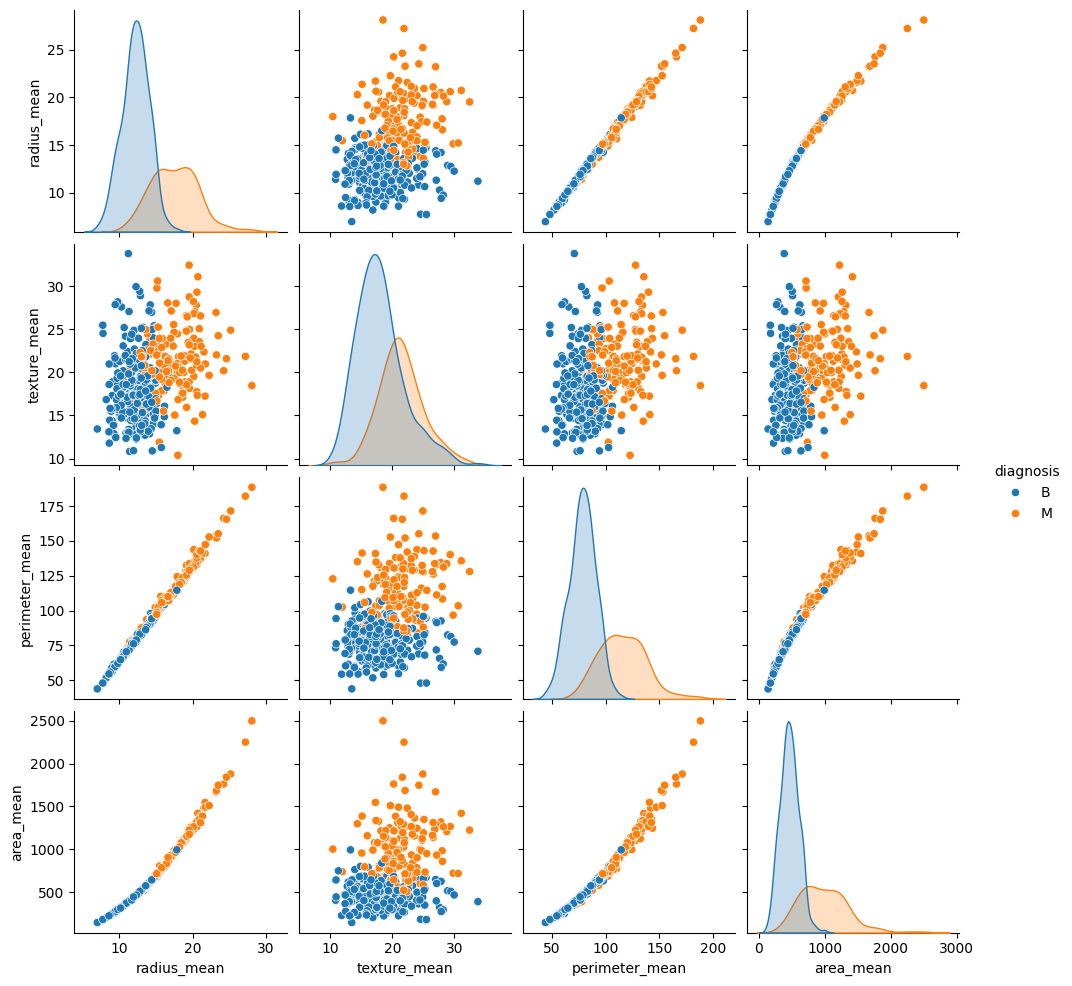

In [14]:
sns.pairplot(train_dataset.iloc[:, 1:6], hue = 'diagnosis', diag_kind='kde');

このペアプロットは、半径、周長、面積などの特定の特徴が高度に相関していることを示しています。これは、腫瘍半径が周長と面積の両方の計算に直接関与しているためです。さらに、悪性診断は多くの特徴でより右に歪んでいるように見えます。

全体の統計も確認してください。各特徴の値の範囲が大きく異なることに注意してください。

In [15]:
train_dataset.describe().transpose()[:10]

count          mean           std         min  \
id                    427.0  2.756014e+07  1.162735e+08  8670.00000   
radius_mean           427.0  1.414331e+01  3.528717e+00     6.98100   
texture_mean          427.0  1.924468e+01  4.113131e+00    10.38000   
perimeter_mean        427.0  9.206759e+01  2.431431e+01    43.79000   
area_mean             427.0  6.563190e+02  3.489106e+02   143.50000   
smoothness_mean       427.0  9.633618e-02  1.436820e-02     0.05263   
compactness_mean      427.0  1.036597e-01  5.351893e-02     0.02344   
concavity_mean        427.0  8.833008e-02  7.965884e-02     0.00000   
concave_poinits_mean  427.0  4.872688e-02  3.853594e-02     0.00000   
symmetry_mean         427.0  1.804597e-01  2.637837e-02     0.12030   

                                25%           50%           75%           max  
id                    865427.500000  905539.00000  8.810829e+06  9.113205e+08  
radius_mean               11.695000      13.43000  1.594000e+01  2.811000e+01  
texture_mean              16.330000      18.84000  2.168000e+01  3.381000e+01  
perimeter_mean            75.235000      86.87000  1.060000e+02  1.885000e+02  
area_mean                420.050000     553.50000  7.908500e+02  2.499000e+03  
smoothness_mean            0.085850       0.09566  1.050000e-01  1.634000e-01  
compactness_mean           0.063515       0.09182  1.296500e-01  3.454000e-01  
concavity_mean             0.029570       0.05999  1.297500e-01  4.268000e-01  
concave_poinits_mean       0.019650       0.03390  7.409500e-02  2.012000e-01  
symmetry_mean              0.161700       0.17840  1.947000e-01  2.906000e-01

範囲に一貫性がない場合は、各特徴の平均がゼロで分散が 1 になるようにデータを標準化することをお勧めします。このプロセスは [正則化](https://developers.google.com/machine-learning/glossary#normalization){:.external} と呼ばれます。

In [16]:
class Normalize(tf.Module):
  def __init__(self, x):
    # Initialize the mean and standard deviation for normalization
    self.mean = tf.Variable(tf.math.reduce_mean(x, axis=0))
    self.std = tf.Variable(tf.math.reduce_std(x, axis=0))

  def norm(self, x):
    # Normalize the input
    return (x - self.mean)/self.std

  def unnorm(self, x):
    # Unnormalize the input
    return (x * self.std) + self.mean

norm_x = Normalize(x_train)
x_train_norm, x_test_norm = norm_x.norm(x_train), norm_x.norm(x_test)

## ロジスティック回帰

ロジスティック回帰モデルを構築する前に、従来の線形回帰との違いを理解することが重要です。

### ロジスティック回帰の基礎

線形回帰は、その入力の線形結合を返し、出力は無制限です。[ロジスティック回帰](https://developers.google.com/machine-learning/glossary#logistic_regression){:.external}の出力は、`(0, 1)` の範囲にあります。各例について、例が*正*クラスに属する確率を表します。

ロジスティック回帰は、従来の線形回帰の連続出力 `(-∞, ∞)` を確率 `(0, 1)` にマッピングします。また、この変換は対称であるため、線形出力の符号を反転すると、元の確率の逆になります。

$Y$ がクラス `1`（腫瘍が悪性）である確率を表すとします。マッピングは、線形回帰出力をクラス `0` ではなく、クラス `1` にある[対数オッズ](https://developers.google.com/machine-learning/glossary#log-odds){:.external} 比率として解釈することで実現できます。

```
$$\ln(\frac{Y}{1-Y}) = wX + b$$
```

$wX + b = z$ を設定すると、この方程式を $Y$ について解くことができます。

```
$$Y = \frac{e^{z}}{1 + e^{z}} = \frac{1}{1 + e^{-z}}$$
```

式 $\frac{1}{1 + e^{-z}}$ は、[シグモイド関数](https://developers.google.com/machine-learning/glossary#sigmoid_function){:.external} $\sigma(z)$ として知られています。したがって、ロジスティック回帰の式は $Y = \sigma(wX + b)$ と記述することができます。

線形出力 `(-∞, ∞)` を `0` と `1` の間に変換するシグモイド関数を視覚化することから始めます。シグモイド関数は `tf.math.sigmoid` で利用できます。

```
$${\mathrm{Y}} = \sigma({\mathrm{X}}w + b)$$
```

これは、それぞれ以下を意味します。

- $\underset{m\times 1}{\mathrm{Y}}$: ターゲットベクトル
- $\underset{m\times n}{\mathrm{X}}$: 特徴行列
- $\underset{n\times 1}w$: 重みベクトル
- $b$: バイアス
- $\sigma$: 出力ベクトルの各要素に適用されるシグモイド関数

線形出力 `(-∞, ∞)` を `0` と `1` の間に変換するシグモイド関数を視覚化することから始めます。シグモイド関数は `tf.math.sigmoid` で利用できます。

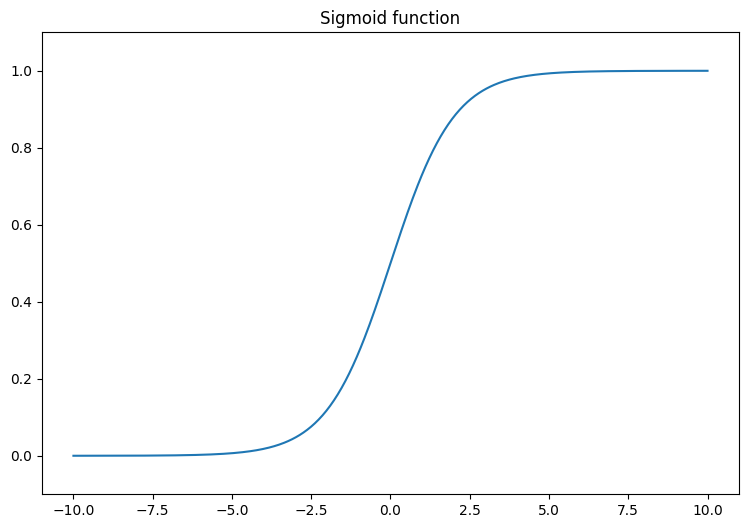

In [17]:
x = tf.linspace(-10, 10, 500)
x = tf.cast(x, tf.float32)
f = lambda x : (1/20)*x + 0.6
plt.plot(x, tf.math.sigmoid(x))
plt.ylim((-0.1,1.1))
plt.title("Sigmoid function");

### 対数損失関数

[対数損失](https://developers.google.com/machine-learning/glossary#Log_Loss){:.external}（バイナリクロスエントロピー損失）は、ロジスティック回帰によるバイナリ分類問題の理想的な損失関数です。各例について、対数損失は、予測された確率と例の真の値の間の類似性を定量化します。 次の式で求めます。

```
ここでは、
```

`tf.nn.sigmoid_cross_entropy_with_logits` 関数を使用して対数損失を計算できます。この関数は、シグモイド活性化を回帰出力に自動的に適用します。

- $\hat{y}$: 予測確率のベクトル
- $y$: 真のターゲットのベクトル

`tf.nn.sigmoid_cross_entropy_with_logits` 関数を使用して対数損失を計算できます。この関数は、シグモイド活性化を回帰出力に自動的に適用します。

In [18]:
def log_loss(y_pred, y):
  # Compute the log loss function
  ce = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=y_pred)
  return tf.reduce_mean(ce)

### 勾配降下法の更新

TensorFlow Core API は、`tf.GradientTape` による自動微分をサポートしています。ここでは、ロジスティック回帰 [勾配降下法の更新](https://developers.google.com/machine-learning/glossary#gradient_descent){:.external} の背後にある数学について簡単に説明します。

上記の対数損失の式で、各 $\hat{y}_i$ は、入力に関して $\sigma({\mathrm{X_i}}w + b)$ と書き直すことができることを思い出してください。

目標は、対数損失を最小限に抑える $w^*$ と $b^*$ を見つけることです。

```
$w$ に対して勾配 $L$ を取ると、以下が得られます。
```

$b$ に対して勾配 $L$ を取ると、以下が得られます。

```
$$\frac{\partial L}{\partial w} = \frac{1}{m}(\sigma({\mathrm{X}}w + b) - y)X$$
```

$b$ に対して勾配 $L$ を取ると、以下が得られます。

```
$$\frac{\partial L}{\partial b} = \frac{1}{m}\sum_{i=1}^{m}\sigma({\mathrm{X_i}}w + b) - y_i$$
```

次に、ロジスティック回帰モデルを構築します。

In [19]:
class LogisticRegression(tf.Module):

  def __init__(self):
    self.built = False
    
  def __call__(self, x, train=True):
    # Initialize the model parameters on the first call
    if not self.built:
      # Randomly generate the weights and the bias term
      rand_w = tf.random.uniform(shape=[x.shape[-1], 1], seed=22)
      rand_b = tf.random.uniform(shape=[], seed=22)
      self.w = tf.Variable(rand_w)
      self.b = tf.Variable(rand_b)
      self.built = True
    # Compute the model output
    z = tf.add(tf.matmul(x, self.w), self.b)
    z = tf.squeeze(z, axis=1)
    if train:
      return z
    return tf.sigmoid(z)

検証するには、トレーニングデータの小さなサブセットに対して、トレーニングされていないモデルが `(0, 1)` の範囲の値を出力することを確認します。

In [20]:
log_reg = LogisticRegression()

In [21]:
y_pred = log_reg(x_train_norm[:5], train=False)
y_pred.numpy()

array([0.9994985 , 0.9978607 , 0.29620072, 0.01979049, 0.3314926 ],
      dtype=float32)

次に、トレーニング中に正しい分類の割合を計算するための精度関数を記述します。予測された確率から分類を取得するには、しきい値よりも高いすべての確率がクラス `1` に属するようにしきい値を設定します。これは、構成可能なハイパーパラメータで、デフォルトで `0.5` に設定できます。

In [22]:
def predict_class(y_pred, thresh=0.5):
  # Return a tensor with  `1` if `y_pred` > `0.5`, and `0` otherwise
  return tf.cast(y_pred > thresh, tf.float32)

def accuracy(y_pred, y):
  # Return the proportion of matches between `y_pred` and `y`
  y_pred = tf.math.sigmoid(y_pred)
  y_pred_class = predict_class(y_pred)
  check_equal = tf.cast(y_pred_class == y,tf.float32)
  acc_val = tf.reduce_mean(check_equal)
  return acc_val

### モデルをトレーニングする

トレーニングにミニバッチを使用すると、メモリ効率と収束の高速化を実現できます。`tf.data.Dataset` API には、バッチ処理とシャッフルに役立つ関数があります。API を使用すると、単純で再利用可能な部分から複雑な入力パイプラインを構築できます。 

In [23]:
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_norm, y_train))
train_dataset = train_dataset.shuffle(buffer_size=x_train.shape[0]).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_norm, y_test))
test_dataset = test_dataset.shuffle(buffer_size=x_test.shape[0]).batch(batch_size)

次に、ロジスティック回帰モデルのトレーニングループを作成します。ループは、モデルのパラメータを繰り返し更新するために、対数損失関数と入力に対するその勾配を利用します。

In [24]:
# Set training parameters
epochs = 200
learning_rate = 0.01
train_losses, test_losses = [], []
train_accs, test_accs = [], []

# Set up the training loop and begin training
for epoch in range(epochs):
  batch_losses_train, batch_accs_train = [], []
  batch_losses_test, batch_accs_test = [], []

  # Iterate over the training data
  for x_batch, y_batch in train_dataset:
    with tf.GradientTape() as tape:
      y_pred_batch = log_reg(x_batch)
      batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Update the parameters with respect to the gradient calculations
    grads = tape.gradient(batch_loss, log_reg.variables)
    for g,v in zip(grads, log_reg.variables):
      v.assign_sub(learning_rate * g)
    # Keep track of batch-level training performance
    batch_losses_train.append(batch_loss)
    batch_accs_train.append(batch_acc)

  # Iterate over the testing data
  for x_batch, y_batch in test_dataset:
    y_pred_batch = log_reg(x_batch)
    batch_loss = log_loss(y_pred_batch, y_batch)
    batch_acc = accuracy(y_pred_batch, y_batch)
    # Keep track of batch-level testing performance
    batch_losses_test.append(batch_loss)
    batch_accs_test.append(batch_acc)

  # Keep track of epoch-level model performance
  train_loss, train_acc = tf.reduce_mean(batch_losses_train), tf.reduce_mean(batch_accs_train)
  test_loss, test_acc = tf.reduce_mean(batch_losses_test), tf.reduce_mean(batch_accs_test)
  train_losses.append(train_loss)
  train_accs.append(train_acc)
  test_losses.append(test_loss)
  test_accs.append(test_acc)
  if epoch % 20 == 0:
    print(f"Epoch: {epoch}, Training log loss: {train_loss:.3f}")

Epoch: 0, Training log loss: 0.661


Epoch: 20, Training log loss: 0.418


Epoch: 40, Training log loss: 0.269


Epoch: 60, Training log loss: 0.178


Epoch: 80, Training log loss: 0.137


Epoch: 100, Training log loss: 0.116


Epoch: 120, Training log loss: 0.106


Epoch: 140, Training log loss: 0.096


Epoch: 160, Training log loss: 0.094


Epoch: 180, Training log loss: 0.089


### パフォーマンス評価

モデルの損失と精度の経時変化を観察します。 

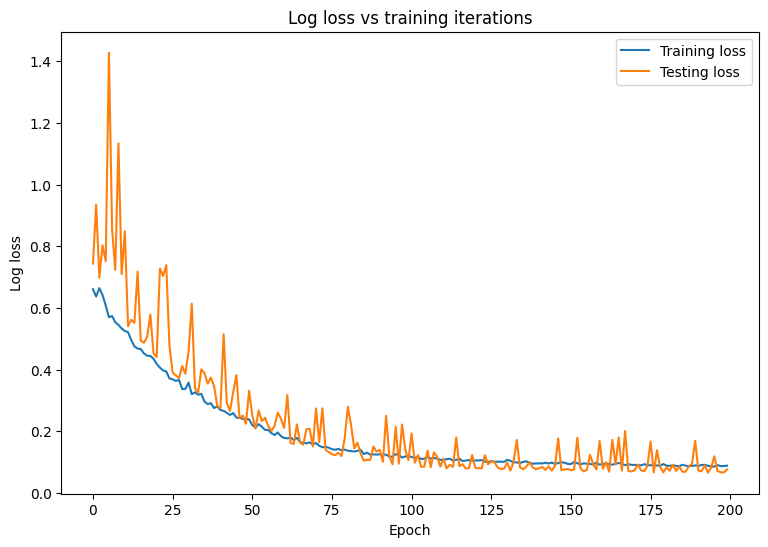

In [25]:
plt.plot(range(epochs), train_losses, label = "Training loss")
plt.plot(range(epochs), test_losses, label = "Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Log loss")
plt.legend()
plt.title("Log loss vs training iterations");

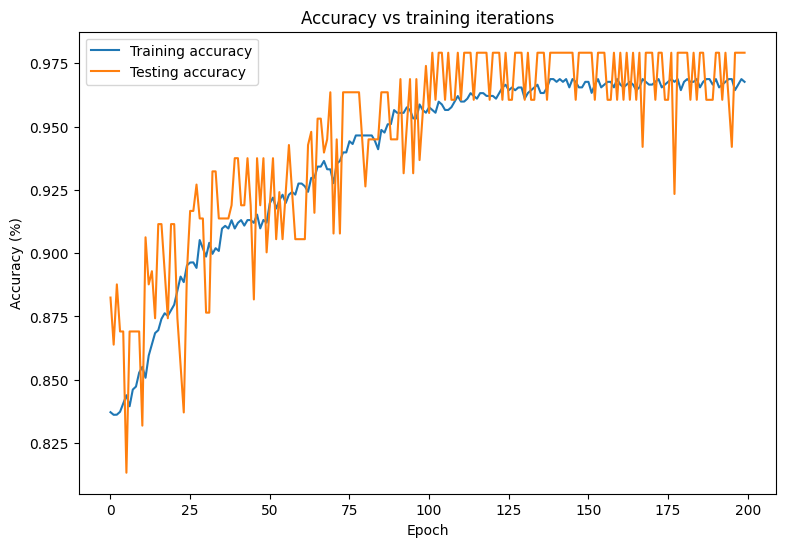

In [26]:
plt.plot(range(epochs), train_accs, label = "Training accuracy")
plt.plot(range(epochs), test_accs, label = "Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.title("Accuracy vs training iterations");

In [27]:
print(f"Final training log loss: {train_losses[-1]:.3f}")
print(f"Final testing log Loss: {test_losses[-1]:.3f}")

Final training log loss: 0.089
Final testing log Loss: 0.077


In [28]:
print(f"Final training accuracy: {train_accs[-1]:.3f}")
print(f"Final testing accuracy: {test_accs[-1]:.3f}")

Final training accuracy: 0.968
Final testing accuracy: 0.979


このモデルは、トレーニングデータセットでの腫瘍の分類に関して高い精度と低い損失を示し、新しいテストデータに対しても一般化されています。さらに、全体的な精度スコアを超える洞察を提供する誤差率を調べることができます。二項分類問題の最も一般的な 2 つの誤差率は、偽陽性率（FPR）と偽陰性率（FNR）です。

この問題では、FPR は、実際には良性である腫瘍のうち、悪性腫瘍と予測される割合です。逆に、FNR は、実際に悪性である腫瘍の中で良性腫瘍と予測される割合です。

分類の精度を評価する [`sklearn.metrics.confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html#sklearn.metrics.confusion_matrix){:.external} を使用して混同行列を計算し、matplotlib を使用して行列を表示します。

In [29]:
def show_confusion_matrix(y, y_classes, typ):
  # Compute the confusion matrix and normalize it
  plt.figure(figsize=(10,10))
  confusion = sk_metrics.confusion_matrix(y.numpy(), y_classes.numpy())
  confusion_normalized = confusion / confusion.sum(axis=1, keepdims=True)
  axis_labels = range(2)
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.4f', square=True)
  plt.title(f"Confusion matrix: {typ}")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

y_pred_train, y_pred_test = log_reg(x_train_norm, train=False), log_reg(x_test_norm, train=False)
train_classes, test_classes = predict_class(y_pred_train), predict_class(y_pred_test)

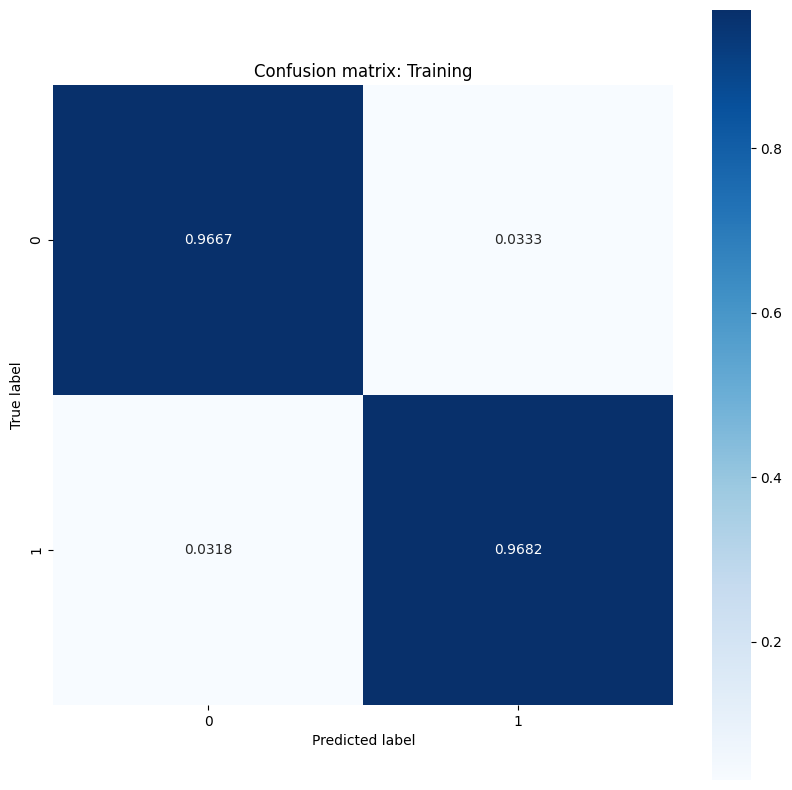

In [30]:
show_confusion_matrix(y_train, train_classes, 'Training')

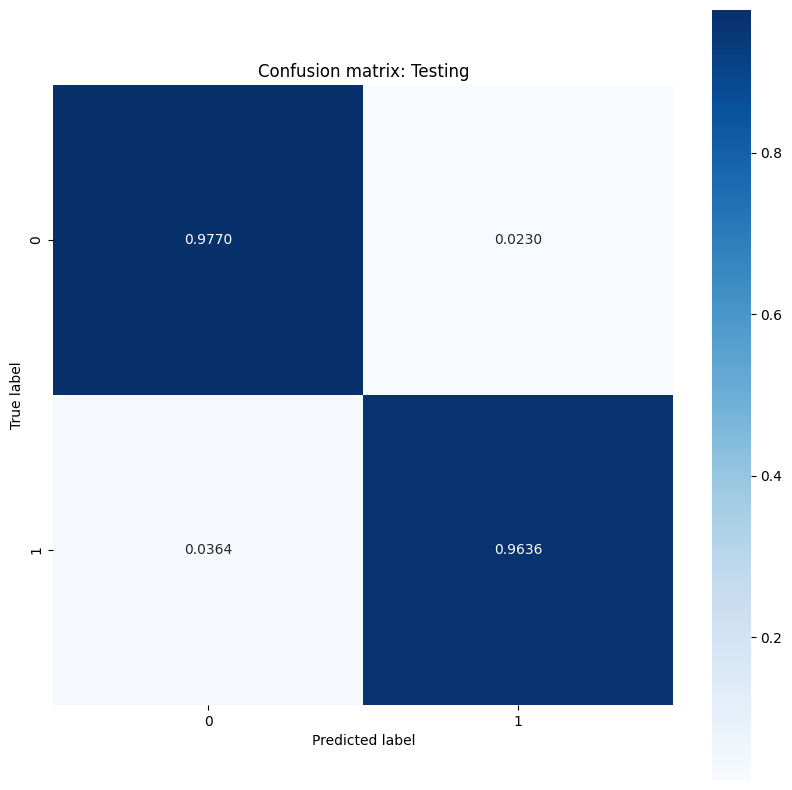

In [31]:
show_confusion_matrix(y_test, test_classes, 'Testing')

誤り率の測定値を観察し、この例のコンテキストでその重要性を解釈します。癌の検出などの多くの医療検査研究では、偽陰性率を低く抑えるために偽陽性率を高くすることは完全に許容され、実際には推奨されます。悪性腫瘍の診断を見逃すリスク（偽陰性）は、良性腫瘍を悪性と誤分類するリスク（偽陽性）よりもはるかに悪いためです。

FPR と FNR を制御するには、確率予測を分類する前にしきい値ハイパーパラメータを変更してみてください。しきい値を低くすると、モデルが悪性腫瘍に分類される可能性が全体的に高くなります。 これにより、必然的に偽陽性の数と FPR が増加しますが、偽陰性の数と FNR の低減にも役立ちます。

## モデルを保存する

まず、生データを取り込み、次の演算を実行するエクスポートモジュールを作成します。

- 正則化
- 確率予測
- クラス予測


In [32]:
class ExportModule(tf.Module):
  def __init__(self, model, norm_x, class_pred):
    # Initialize pre- and post-processing functions
    self.model = model
    self.norm_x = norm_x
    self.class_pred = class_pred

  @tf.function(input_signature=[tf.TensorSpec(shape=[None, None], dtype=tf.float32)])
  def __call__(self, x):
    # Run the `ExportModule` for new data points
    x = self.norm_x.norm(x)
    y = self.model(x, train=False)
    y = self.class_pred(y)
    return y 

In [33]:
log_reg_export = ExportModule(model=log_reg,
                              norm_x=norm_x,
                              class_pred=predict_class)

モデルをその時点の状態で保存する場合は、`tf.saved_model.save` 関数を使用して保存できます。保存されたモデルを読み込んで予測を行うには、`tf.saved_model.load` 関数を使用します。

In [34]:
models = tempfile.mkdtemp()
save_path = os.path.join(models, 'log_reg_export')
tf.saved_model.save(log_reg_export, save_path)

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpx07zo80u/log_reg_export/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpx07zo80u/log_reg_export/assets


In [35]:
log_reg_loaded = tf.saved_model.load(save_path)
test_preds = log_reg_loaded(x_test)
test_preds[:10].numpy()

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1.], dtype=float32)

## 結論

このノートブックでは、ロジスティック回帰問題を扱うためのテクニックをいくつか紹介しました。以下は、役に立つかもしれないその他のヒントです。

- [TensorFlow Core API](https://www.tensorflow.org/guide/core) を使用して、高度な設定が可能な機械学習ワークフローを構築できます。
- 誤り率を分析することにより、全体的な精度スコアだけでなく、分類モデルのパフォーマンスについてより多くの洞察を得られます。
- 過適合は、ロジスティック回帰モデルのもう 1 つの一般的な問題ですが、このチュートリアルでは問題になりませんでした。 詳しくは、[過学習と過少学習](../../tutorials/keras/overfit_and_underfit.ipynb)のチュートリアルを参照してください。

TensorFlow Core API のその他の使用例については、[ガイド](https://www.tensorflow.org/guide/core)をご覧ください。データの読み込みと準備についてさらに学習するには、[画像データの読み込み](../../tutorials/load_data/images.ipynb)または [CSV データの読み込み](../../tutorials/load_data/csv.ipynb)に関するチュートリアルをご覧ください。